In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import CorrMaps as CM

# Correlation maps

```MIfile``` class can also be used as an input for ```CorrMaps``` class, which computes correlation maps.
We initialize a ```CorrMaps``` class like this:

```python
corrmap = CM.CorrMaps(MIin, outFolder, lagList, KernelSpecs, imgRange=None, cropROI=None)
```

where:
- ```MIin``` is the input ```MIfile``` class
- ```outFolder``` (```str```) is the output folder where correlation maps will be saved
- ```lagList``` is a list of lagtimes (```int```, in image units, independent on the step specified in ```imgRange```). One correlation map will be computer for each lagtime
- ```KernelSpecs``` is a ```DSH.Kernel``` object containing the parameters for local averaging. It can be initialized using ```DSH.Kernel()``` and initialized using ```Kernel.initialize(shape, kernel_type, params={}, n_dim=2, padding=False, convolve_kwargs={})```, where:
    - ```shape``` (```int``` or n-dimensional list of ```int```) is the shape of the output kernel matrix.
    - ```kernel_type``` (```str```) is the kernel type. For the moment the only supported types are ```'flat'```, a uniform kernel, and ```'Gauss'```, a Gaussian kernel, which requires specification of ```'sigma'``` (```float``` or n-dimensional tuple), the Gaussian standard deviation. Eventual additional parameters are specified in the ```params``` variable (```dict```).
    - ```n_dim``` (```int```) is the number of dimensions
    - ```padding``` (```bool```): if ```True```, the input images will be padded with zeroes such that the output correlation maps will have the same shape as the input images. Otherwise, the correlation maps will have the margins trimmed of an amount equal to the kernel size.
    - ```convolve_kwargs``` is a ```dict``` containing eventual extra keywords that will be passed to ```scipy.signal.convolve2d```
- ```imgRange``` is a list of 3 ```int``` of the form ```[z_min, z_max, z_step]```.
- ```cropROI``` contains ROI specs in the same form as the one specified for MIfile class

<Kernel [2D Gauss], 11x11, s=(2.5;1.5)>


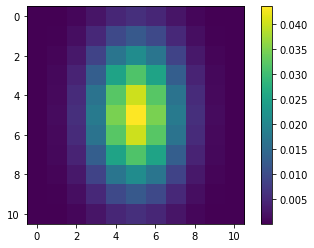

In [2]:
KernelSpecs = DSH.Kernel.Kernel()
KernelSpecs.Initialize(shape=11, kernel_type='Gauss', params={'sigma':[2.5, 1.5]}, padding=True)
print(KernelSpecs)
plt.imshow(KernelSpecs.ToMatrix())
plt.colorbar()

To initialize ```CorrMaps```, let's first load a ```MIfile``` object (see tutorial 1 for details)

In [3]:
froot = os.path.join(os.path.dirname(MI.__file__), 'test')
fname = os.path.join(froot, 'MIfile.dat')
metadata_fname = os.path.join(froot, 'metadata.ini')
mi_file = MI.MIfile(fname, metadata_fname)
test_ROI = [200, 100, -1, 50]

Now let's initialize ```CorrMaps``` using this ```MIfile```:

In [4]:
corrmap = CM.CorrMaps(mi_file, froot, [1], KernelSpecs, imgRange=None, cropROI=test_ROI)

Once again, initialization only computes analysis parameters. To actually compute the correlation maps we need to call:

```python
cmap_list = corrmap.Compute(silent=True, return_maps=False)
```

Correlation maps will only returned if argument ```return_maps``` is set to ```True```. However, be aware that this may lead to heavy memory usage, and that no memory check will be done. When ```return_maps==False```, ```None``` will be returned. For testing purposes, we compute correlation maps on a small subset of the MIfile, and we return the output

In [5]:
cmap_list = corrmap.Compute(silent=False, return_maps=True)

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...
  STEP 2: Computing contrast...
  STEP 3: Computing correlations...
     ...lag 1
Procedure completed in 0.0 seconds!


check out one random frame from each correlation map:

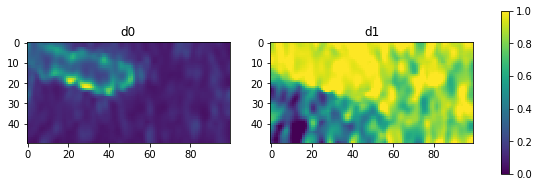

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
tidx = 0
lagidx = 1
ax1.set_title('d0')
ax1.imshow(cmap_list[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d'+str(lagidx))
cbar = ax2.imshow(cmap_list[lagidx][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

once again, details about the CorrMap class instance can be printed to output by simply doing:

In [7]:
print(corrmap)


|-----------------|
| CorrMaps class: |
|-----------------+---------------
| MI input        : <MIfile: 0+2x200x300x1 bytes>
| output folder   : C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\test
| lag times (01)  : [1]
| image range     : [0, 2, 1]
| crop ROI        : [200, 100, 100, 50]
| Kernel          : <Kernel [2D Gauss], 11x11, s=(2.5;1.5)>
|-----------------+---------------


let's see what happens if we don't use padding:

In [8]:
KernelSpecs.SetPadding(False)
corrmap_nopad = CM.CorrMaps(mi_file, froot, [1], KernelSpecs, imgRange=None, cropROI=test_ROI)
cmap_list_nopad = corrmap_nopad.Compute(silent=False, return_maps=True)

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...
  STEP 2: Computing contrast...
  STEP 3: Computing correlations...
     ...lag 1
Procedure completed in 0.0 seconds!


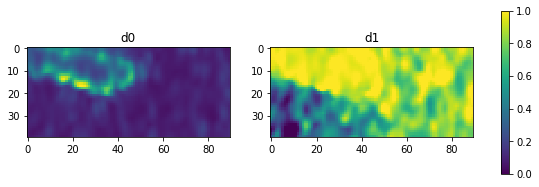

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.set_title('d0')
ax1.imshow(cmap_list_nopad[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d'+str(lagidx))
cbar = ax2.imshow(cmap_list_nopad[lagidx][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

To check that everywhere away from the boundary the two methods are the same we compute the difference:

In [10]:
print(np.max(np.absolute(np.subtract(cmap_list[1][:, 5:-5, 5:-5],cmap_list_nopad[1]))))

0.014739351
